# Notebook for the RL demonstration

In [5]:
import torch
import optuna

import blockulib.models as blom
from blockulib.experiments import test_playing_loop_timing
from blockulib.pipelines import Configs
from blockulib.playing import play_games, RandomLoop, ModelBasedLoop, YEstimator
from blockulib.utils import DeepList, ShallowList
from blockulib.data import DataOrganizer, NMostPopular
from blockulib.training import ModelGridSearch, train_model

# Initial Data
Before including any model in the loop, we will first establish a baseline value function for each position - the expected game lenbgth, from that position, when acting according to a random policy.

## Possible states
First, we need to get a grasp of the possible boards state, that our model will be trained on. For that, let's play approx. $2^{15}$ games according to a random policy, to get a diverse collection of possible states.

Playing 1 games at once 8 times took 0.04761700000381097: ratio of 5.952125e-03 s/game
Playing 2 games at once 8 times took 0.061823500000173226: ratio of 3.863969e-03 s/game
Playing 4 games at once 8 times took 0.08971590000146534: ratio of 2.803622e-03 s/game
Playing 8 games at once 8 times took 0.14673469999979716: ratio of 2.292730e-03 s/game
Playing 16 games at once 8 times took 0.2546468000000459: ratio of 1.989428e-03 s/game
Playing 32 games at once 8 times took 0.4585099000032642: ratio of 1.791054e-03 s/game
Playing 64 games at once 8 times took 0.8720123000020976: ratio of 1.703149e-03 s/game
Playing 128 games at once 8 times took 1.717309400002705: ratio of 1.677060e-03 s/game
Playing 256 games at once 8 times took 3.6929841000019223: ratio of 1.803215e-03 s/game
Playing 512 games at once 8 times took 8.997845900004904: ratio of 2.196740e-03 s/game
Playing 1024 games at once 8 times took 24.614318799998728: ratio of 3.004678e-03 s/game


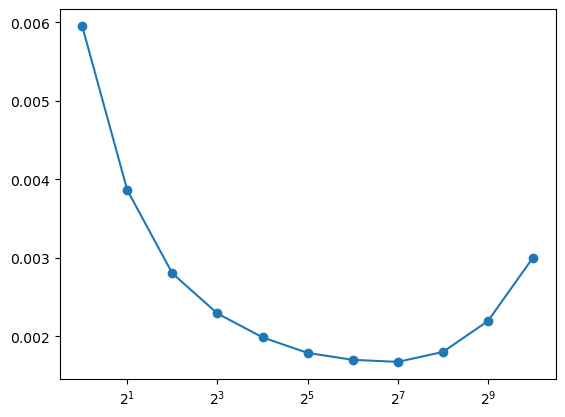

Best ratio achieved for 128 games at once with a ratio of 1.677060e-03 s/game


Playing games: 100%|██████████| 256/256 [00:52<00:00,  4.85it/s]


Mean MPG : 15.4530029296875


In [6]:
games_at_once = test_playing_loop_timing(RandomLoop, max_exp = 10, pos_list_type  = DeepList)

play_games_config = Configs.play_random_config(num_games = 32768, games_at_once = games_at_once, save = True)
play_games(**play_games_config)

Then we filter out the $2^{15}$ most frequently visited states among all the games

In [8]:
n_most_popular_config = Configs.n_most_popular_config(top_n = 32768)
x_transform = NMostPopular()
x_transform(**n_most_popular_config)

32768 boards requested, out of 474895
Threshold set at 2, 30180 places left


## Estimating Random Policy's value function
Now, we can try estimating the value function, of each of the selected $2^{15}$ boards.  
To do that, let's launch 128 different games from each position, and average out the rewards from all games.

Playing 1 games at once 8 times took 0.04716789999656612: ratio of 5.895987e-03 s/game
Playing 2 games at once 8 times took 0.059300499997334555: ratio of 3.706281e-03 s/game
Playing 4 games at once 8 times took 0.08970080000290181: ratio of 2.803150e-03 s/game
Playing 8 games at once 8 times took 0.15497099999629427: ratio of 2.421422e-03 s/game
Playing 16 games at once 8 times took 0.26577499999984866: ratio of 2.076367e-03 s/game
Playing 32 games at once 8 times took 0.5452874000038719: ratio of 2.130029e-03 s/game
Playing 64 games at once 8 times took 0.8699677000040538: ratio of 1.699156e-03 s/game
Playing 128 games at once 8 times took 1.5783184000028996: ratio of 1.541327e-03 s/game
Playing 256 games at once 8 times took 3.120798600000853: ratio of 1.523827e-03 s/game
Playing 512 games at once 8 times took 7.829263400002674: ratio of 1.911441e-03 s/game
Playing 1024 games at once 8 times took 24.262045199997374: ratio of 2.961675e-03 s/game


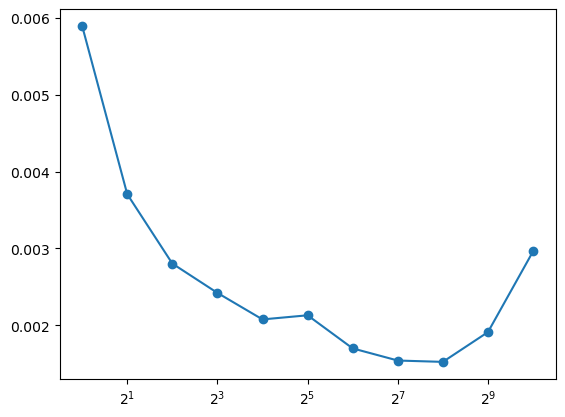

Best ratio achieved for 256 games at once with a ratio of 1.523827e-03 s/game


In [10]:
games_per_board = 128
games_at_once = max(test_playing_loop_timing(RandomLoop, max_exp = 10, pos_list_type  = ShallowList), games_per_board)

In [6]:
estimator = YEstimator(games_at_once = games_at_once, games_per_board = games_per_board)
estimator(loop_type = RandomLoop)

2 boards will be processed at once, with 128 games per board (256 games at once)


Estimating ys: 100%|██████████| 16384/16384 [43:00<00:00,  6.35it/s] 


## Data pre-processsing and model training

First, let's standard scale the y's

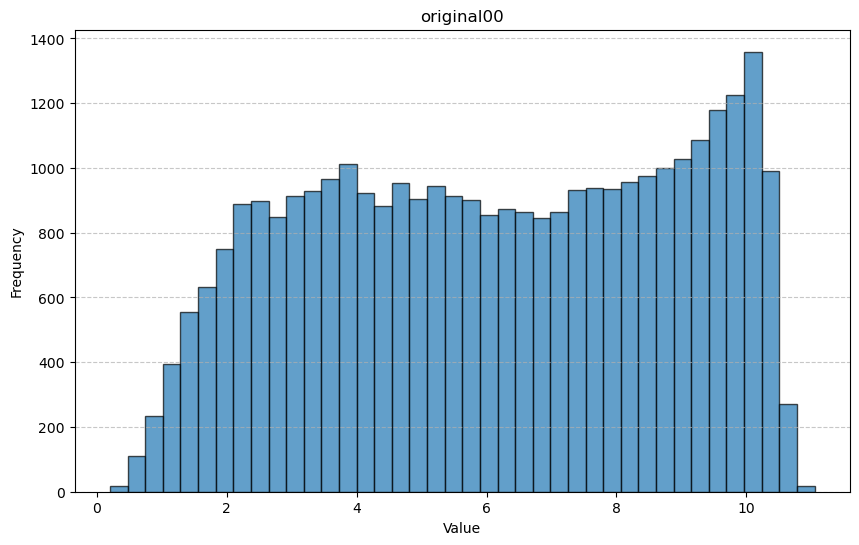

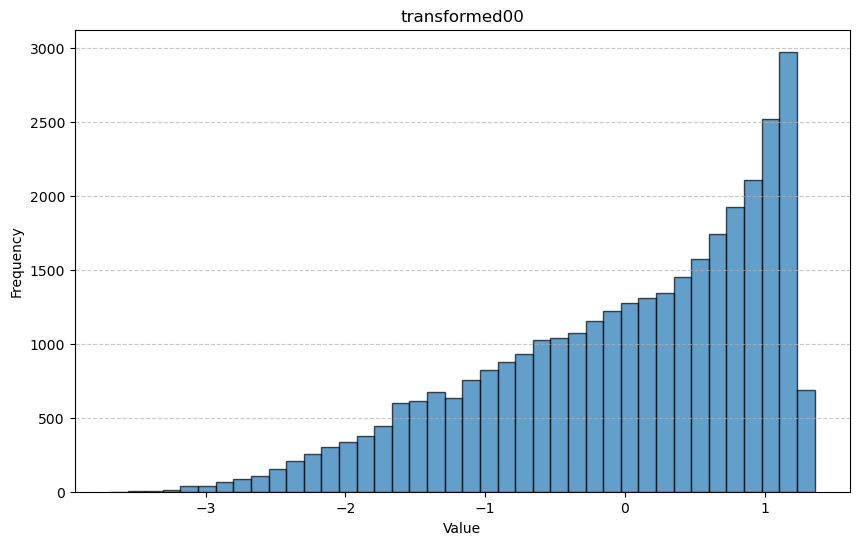

torch.Size([32768])


In [4]:
dorg = DataOrganizer()
dorg(iteration = 0, prep_data = False, show = True, num_bins = 40)

Next, we perform a Grid Search, to find the best architecture and its' hyperparameters for a model for this dataset.

In [7]:
architecture_list = [blom.LinearModel, blom.SimpleModel, blom.ConvModel, blom.TrikowyModel]

study = optuna.create_study(direction="minimize", study_name = "Grid Search for best value prediction model")
optimizer = ModelGridSearch(architecture_list = architecture_list)
study.optimize(optimizer.objective, n_trials=32)

[I 2025-08-17 12:43:43,713] A new study created in memory with name: Grid Search for best value prediction model


Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s]
[I 2025-08-17 12:44:09,376] Trial 0 finished with value: 0.04012992411488163 and parameters: {'init_config_index': 2, 'lr': 0.016282023589267013, 'batch_size': 128}. Best is trial 0 with value: 0.04012992411488163.


Ended training with the best valid loss of 0.04012992411488163 and test loss of: 0.035835007745585026
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.78it/s]
[I 2025-08-17 12:44:22,630] Trial 1 finished with value: 0.15944183492233152 and parameters: {'init_config_index': 1, 'lr': 0.015532673274337504, 'batch_size': 512}. Best is trial 0 with value: 0.04012992411488163.


Ended training with the best valid loss of 0.15944183492233152 and test loss of: 0.1701186523546269
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:16<00:00,  3.10it/s]
[I 2025-08-17 12:44:38,743] Trial 2 finished with value: 0.04473770732908282 and parameters: {'init_config_index': 3, 'lr': 0.002380825986598254, 'batch_size': 512}. Best is trial 0 with value: 0.04012992411488163.


Ended training with the best valid loss of 0.04473770732908282 and test loss of: 0.042374753115569666
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:19<00:00,  2.53it/s]
[I 2025-08-17 12:44:58,552] Trial 3 finished with value: 0.05267468009578827 and parameters: {'init_config_index': 3, 'lr': 0.0010773747870465198, 'batch_size': 256}. Best is trial 0 with value: 0.04012992411488163.


Ended training with the best valid loss of 0.05267468009578827 and test loss of: 0.051093341513836134
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:30<00:00,  1.62it/s]
[I 2025-08-17 12:45:29,442] Trial 4 finished with value: 0.035667913038820644 and parameters: {'init_config_index': 3, 'lr': 0.012853286266792689, 'batch_size': 128}. Best is trial 4 with value: 0.035667913038820644.


Ended training with the best valid loss of 0.035667913038820644 and test loss of: 0.03641920070896288
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:15<00:00,  3.23it/s]
[I 2025-08-17 12:45:44,968] Trial 5 finished with value: 0.038699081552610606 and parameters: {'init_config_index': 3, 'lr': 0.004386755321089405, 'batch_size': 512}. Best is trial 4 with value: 0.035667913038820644.


Ended training with the best valid loss of 0.038699081552610606 and test loss of: 0.035926154803576756
Initiated Trainer for architecture = <class 'blockulib.models.LinearModel'>


Epoch: 100%|██████████| 50/50 [00:15<00:00,  3.31it/s]
[I 2025-08-17 12:46:00,066] Trial 6 finished with value: 0.1247944569401301 and parameters: {'init_config_index': 0, 'lr': 0.0021863189705662186, 'batch_size': 128}. Best is trial 4 with value: 0.035667913038820644.


Ended training with the best valid loss of 0.1247944569401301 and test loss of: 0.12064197495338719
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:25<00:00,  1.97it/s]
[I 2025-08-17 12:46:25,466] Trial 7 finished with value: 0.028290439344527702 and parameters: {'init_config_index': 2, 'lr': 0.001953109103219475, 'batch_size': 128}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.028290439344527702 and test loss of: 0.029048610237638217
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.76it/s]
[I 2025-08-17 12:46:38,765] Trial 8 finished with value: 0.02958222130252422 and parameters: {'init_config_index': 2, 'lr': 0.002595133051616579, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.02958222130252422 and test loss of: 0.0298051247711421
Initiated Trainer for architecture = <class 'blockulib.models.LinearModel'>


Epoch: 100%|██████████| 50/50 [00:09<00:00,  5.19it/s]
[I 2025-08-17 12:46:48,419] Trial 9 finished with value: 0.12109113857434234 and parameters: {'init_config_index': 0, 'lr': 0.008436085557368527, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.12109113857434234 and test loss of: 0.12681140433024954
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:16<00:00,  3.09it/s]
[I 2025-08-17 12:47:04,647] Trial 10 finished with value: 0.1870657064526432 and parameters: {'init_config_index': 1, 'lr': 0.0010025776930879745, 'batch_size': 256}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.1870657064526432 and test loss of: 0.17074618322350174
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:24<00:00,  2.02it/s]
[I 2025-08-17 12:47:29,443] Trial 11 finished with value: 0.029831738896741837 and parameters: {'init_config_index': 2, 'lr': 0.0021874706622568548, 'batch_size': 128}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.029831738896741837 and test loss of: 0.031214866361463985
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.71it/s]
[I 2025-08-17 12:47:42,932] Trial 12 finished with value: 0.03165943089739045 and parameters: {'init_config_index': 2, 'lr': 0.0038798995327359144, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.03165943089739045 and test loss of: 0.028948322031732227
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:20<00:00,  2.50it/s]
[I 2025-08-17 12:48:02,972] Trial 13 finished with value: 0.15063591836791834 and parameters: {'init_config_index': 1, 'lr': 0.0016496921915407348, 'batch_size': 128}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.15063591836791834 and test loss of: 0.14751529546274367
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
[I 2025-08-17 12:48:19,370] Trial 14 finished with value: 0.031511677163393786 and parameters: {'init_config_index': 2, 'lr': 0.0066318992625481864, 'batch_size': 256}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.031511677163393786 and test loss of: 0.03140597847774329
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:12<00:00,  3.98it/s]
[I 2025-08-17 12:48:31,966] Trial 15 finished with value: 0.029257698846990875 and parameters: {'init_config_index': 2, 'lr': 0.001540190702912504, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.029257698846990875 and test loss of: 0.02915549689041593
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:20<00:00,  2.48it/s]
[I 2025-08-17 12:48:52,165] Trial 16 finished with value: 0.15868166009494133 and parameters: {'init_config_index': 1, 'lr': 0.0015719380347108316, 'batch_size': 128}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.15868166009494133 and test loss of: 0.16692178732998894
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:24<00:00,  2.08it/s]
[I 2025-08-17 12:49:16,223] Trial 17 finished with value: 0.031107569762671112 and parameters: {'init_config_index': 2, 'lr': 0.0033411106092820705, 'batch_size': 128}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.031107569762671112 and test loss of: 0.030883259326674278
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:11<00:00,  4.40it/s]
[I 2025-08-17 12:49:27,609] Trial 18 finished with value: 0.15575784231123352 and parameters: {'init_config_index': 1, 'lr': 0.0014378459257528408, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.15575784231123352 and test loss of: 0.15738122850010808
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:18<00:00,  2.73it/s]
[I 2025-08-17 12:49:45,958] Trial 19 finished with value: 0.03605446772980926 and parameters: {'init_config_index': 3, 'lr': 0.006156140742751898, 'batch_size': 256}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.03605446772980926 and test loss of: 0.03726769085810939
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:12<00:00,  3.90it/s]
[I 2025-08-17 12:49:58,782] Trial 20 finished with value: 0.02851501191752408 and parameters: {'init_config_index': 2, 'lr': 0.002897982446313105, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.02851501191752408 and test loss of: 0.029922281825323273
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.82it/s]
[I 2025-08-17 12:50:11,889] Trial 21 finished with value: 0.03591033602509901 and parameters: {'init_config_index': 2, 'lr': 0.0030429601273085764, 'batch_size': 512}. Best is trial 7 with value: 0.028290439344527702.


Ended training with the best valid loss of 0.03591033602509901 and test loss of: 0.0369707508956764
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.80it/s]
[I 2025-08-17 12:50:25,082] Trial 22 finished with value: 0.02619682668412032 and parameters: {'init_config_index': 2, 'lr': 0.001784846440316518, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.02619682668412032 and test loss of: 0.026877409658887273
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]
[I 2025-08-17 12:50:38,227] Trial 23 finished with value: 0.02690204259783916 and parameters: {'init_config_index': 2, 'lr': 0.0019419877288105738, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.02690204259783916 and test loss of: 0.029290017872812327
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:10<00:00,  4.56it/s]
[I 2025-08-17 12:50:49,223] Trial 24 finished with value: 0.17445515297370318 and parameters: {'init_config_index': 1, 'lr': 0.0018430854313874223, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.17445515297370318 and test loss of: 0.14685940170910142
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s]
[I 2025-08-17 12:51:12,621] Trial 25 finished with value: 0.028264556011905386 and parameters: {'init_config_index': 2, 'lr': 0.0013081345873020272, 'batch_size': 128}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.028264556011905386 and test loss of: 0.02986623535741565
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:15<00:00,  3.19it/s]
[I 2025-08-17 12:51:28,314] Trial 26 finished with value: 0.055177165137093816 and parameters: {'init_config_index': 3, 'lr': 0.0012019898675319663, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.055177165137093816 and test loss of: 0.0587578798994663
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.77it/s]
[I 2025-08-17 12:51:41,599] Trial 27 finished with value: 0.027128931430461842 and parameters: {'init_config_index': 2, 'lr': 0.0013539478866682868, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.027128931430461842 and test loss of: 0.030323021118988124
Initiated Trainer for architecture = <class 'blockulib.models.SimpleModel'>


Epoch: 100%|██████████| 50/50 [00:11<00:00,  4.24it/s]
[I 2025-08-17 12:51:53,400] Trial 28 finished with value: 0.1499169645511313 and parameters: {'init_config_index': 1, 'lr': 0.001244937795547275, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.1499169645511313 and test loss of: 0.15197021080602185
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:12<00:00,  3.99it/s]
[I 2025-08-17 12:52:05,949] Trial 29 finished with value: 0.03484962133280109 and parameters: {'init_config_index': 2, 'lr': 0.0053336580061636996, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.03484962133280109 and test loss of: 0.034566976625653056
Initiated Trainer for architecture = <class 'blockulib.models.TrikowyModel'>


Epoch: 100%|██████████| 50/50 [00:15<00:00,  3.28it/s]
[I 2025-08-17 12:52:21,209] Trial 30 finished with value: 0.048422979800461084 and parameters: {'init_config_index': 3, 'lr': 0.001865574004510851, 'batch_size': 512}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.048422979800461084 and test loss of: 0.04877317586312906
Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch: 100%|██████████| 50/50 [00:22<00:00,  2.19it/s]
[I 2025-08-17 12:52:44,094] Trial 31 finished with value: 0.029475332738605736 and parameters: {'init_config_index': 2, 'lr': 0.0013105053677170049, 'batch_size': 128}. Best is trial 22 with value: 0.02619682668412032.


Ended training with the best valid loss of 0.029475332738605736 and test loss of: 0.03179613515498218


In [27]:
train_init_config = study.best_trial.user_attrs['train_init_config']
train_save_config = {
    'save_path' : "models/conv_model.pth"
}

train_config = study.best_trial.user_attrs['train_config']
train_config['save_best'] = True
train_config['log_every'] = 10

train_model(train_init_config = train_init_config, train_config = train_config, train_save_config = train_save_config)

Initiated Trainer for architecture = <class 'blockulib.models.ConvModel'>


Epoch:   2%|▏         | 1/50 [00:00<00:24,  1.97it/s]

Succesfully saved model


Epoch:   4%|▍         | 2/50 [00:00<00:17,  2.79it/s]

Succesfully saved model


Epoch:   6%|▌         | 3/50 [00:01<00:14,  3.17it/s]

Succesfully saved model


Epoch:   8%|▊         | 4/50 [00:01<00:13,  3.45it/s]

Succesfully saved model


Epoch:  10%|█         | 5/50 [00:01<00:12,  3.57it/s]

Succesfully saved model


Epoch:  14%|█▍        | 7/50 [00:02<00:12,  3.40it/s]

Succesfully saved model


Epoch:  18%|█▊        | 9/50 [00:02<00:10,  3.73it/s]

Succesfully saved model


Epoch:  20%|██        | 10/50 [00:02<00:10,  3.82it/s]

Epoch [10/50], Loss: 0.0320, Valid Loss: 0.0431


Epoch:  24%|██▍       | 12/50 [00:03<00:10,  3.76it/s]

Succesfully saved model


Epoch:  28%|██▊       | 14/50 [00:03<00:09,  3.67it/s]

Succesfully saved model


Epoch:  32%|███▏      | 16/50 [00:04<00:11,  3.02it/s]

Succesfully saved model


Epoch:  40%|████      | 20/50 [00:05<00:07,  3.81it/s]

Epoch [20/50], Loss: 0.0257, Valid Loss: 0.0316


Epoch:  50%|█████     | 25/50 [00:06<00:06,  3.94it/s]

Succesfully saved model


Epoch:  60%|██████    | 30/50 [00:08<00:04,  4.16it/s]

Epoch [30/50], Loss: 0.0173, Valid Loss: 0.0379


Epoch:  80%|████████  | 40/50 [00:10<00:02,  4.08it/s]

Epoch [40/50], Loss: 0.0134, Valid Loss: 0.0330


Epoch: 100%|██████████| 50/50 [00:13<00:00,  3.81it/s]

Epoch [50/50], Loss: 0.0096, Valid Loss: 0.0345
Ended training with the best valid loss of 0.030689357227946308 and test loss of: 0.02835975099453884


(0.02835975099453884, 0.030689357227946308)

In [13]:
loop = ModelBasedLoop(pos_list_type = ShallowList)
playing_config = {
    'num_games' : 1024,
    'pick_moves_config' : {
        'temperature' : 0.7,
        'top_k' : 1
    }
}
_, lengths = loop(**playing_config)
print(lengths)
print(f"MPG: {lengths.mean()}")

tensor([120.,  54., 407.,  ..., 353.,  60.,  69.])
MPG: 160.484375
